In [3]:
!pip install fastmri
!pip install torchinfo

In [4]:
# Do all of common functions here
import numpy as np
import pywt
import bokeh
import bokeh.plotting as bpl
from bokeh.models import ColorBar, BasicTicker, LinearColorMapper
import matplotlib
import fastmri
from fastmri.data import transforms as T
from PIL import Image

# Some functions taken from HW1 - MRI

## Standard basis element function for matrix space (ZERO-INDEXED)
def stdbel(n, i, j):
  E = np.zeros((n, n))
  E[i, j] = 1
  return E

## Try to do something like imagesc in MATLAB using Bokeh tools.
def imagesc(M, title=''):
  m, n = M.shape
  
  # 600 px should be good; calculate ph to try to get aspect ratio right
  pw = 600
  ph = round(1.0 * pw * m / n)
  h = bpl.figure(plot_width = pw, plot_height = ph, x_range=(0, 1.0*n),
                 y_range=(0, 1.0*m), toolbar_location='below',
                 title=title, match_aspect=True
                )
  
  minval = np.min(M)
  maxval = np.max(M)
  
  color_mapper = LinearColorMapper(palette="Greys256", low=minval, high=maxval)
  h.image(image=[M], x=0, y=0, dw=1.0*n, dh=1.0*m, color_mapper=color_mapper)
  
  color_bar = ColorBar(color_mapper=color_mapper, ticker=BasicTicker(),
                      label_standoff=12, border_line_color=None, location=(0, 0))
  
  h.add_layout(color_bar, 'right')
  

  bpl.show(h)
  return h

# Get a default slice object for a multilevel wavelet transform
# Used to abstract this annoying notation out of the transform...
def default_slices(levels, n):
  c = pywt.wavedec2(np.zeros((n, n)), 'db4', mode='periodization', level=levels)
  bye, slices = pywt.coeffs_to_array(c)
  return slices

# Wrapper for forward discrete wavelet transform
# Output data as a matrix (we don't care about tuple format)
def dwt(levels, sdom_data):
  c = pywt.wavedec2(sdom_data, 'db4', mode='periodization', level=levels)
  output, bye = pywt.coeffs_to_array(c)
  return output

# Wrapper for inverse discrete wavelet transform
# Expect wdom_data as a matrix (we don't care about tuple format)
def idwt(levels, wdom_data, slices=None):
  n = wdom_data.shape[0]
  if slices is None:
    slices = default_slices(levels, n)
  c = pywt.array_to_coeffs(wdom_data, slices, output_format='wavedec2')
  return pywt.waverec2(c, 'db4', mode='periodization')

def frob_error(X_reconstruct,X):
  num = np.linalg.norm(X_reconstruct-X, ord='fro')
  den = np.linalg.norm(X, ord='fro')
  return num/den

def k_encode(k,X):
  X_dwt = dwt(levels=3,sdom_data=X)
  X_sorted = np.sort(np.absolute(np.array(X_dwt)).flatten(),kind='quicksort')[::-1]
  k_threshold = X_sorted[k-1]
  X_dwt[np.absolute(X_dwt)<k_threshold] = 0
  X_encode = X_dwt
  return X_encode

def decode(X_encode):
  X_reconstruct = idwt(levels=3, wdom_data=X_encode)
  return X_reconstruct

def k_reconstruct(k,X_dwt):
  X_sorted = np.sort(np.absolute(np.array(X_dwt)).flatten(),kind='quicksort')[::-1]
  k_threshold = X_sorted[k-1]
  X_dwt[np.absolute(X_dwt)<k_threshold] = 0
  X_reconstruct = idwt(levels=3, wdom_data=X_dwt)
  return X_reconstruct

def evaluate_k(k,X):
  X_encode = k_encode(k,X)
  X_reconstruct = decode(X_encode)
  error = frob_error(X_reconstruct,X)
  return error

def resize_scan(X):
    # Raw image is a rectangle, crop to be square
    y_min = int((768-396)/2)
    y_max = int((768-396)/2+396)
    X_square = X[y_min:y_max,:]
    # Crop further to zone of interest to get a 256x256 image
    X_square_256 = X_square[50:50+256,70:70+256]
    return X_square_256

def to_jpeg(X,X_true):
    matplotlib.image.imsave('../images/X.jpg', X)
    image = Image.open('../images/X.jpg').convert('L')
    # convert image to numpy array
    X_jpeg = np.asarray(image.getdata()).reshape(image.size)
    X_jpeg = X_jpeg*np.max(X_true)/255
    return X_jpeg

def combine_all_coils(volume_kspace,slice_idx):
    slice_kspace = volume_kspace[slice_idx]
    slice_kspace2 = T.to_tensor(slice_kspace)      # Convert from numpy array to pytorch tensor
    slice_image = fastmri.ifft2c(slice_kspace2)           # Apply Inverse Fourier Transform to get the complex image
    slice_image_abs = fastmri.complex_abs(slice_image)   # Compute absolute value to get a real image
    slice_image_rss = fastmri.rss(slice_image_abs, dim=0)
    return slice_image_rss.numpy()

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import dataloader
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from IPython.display import display
import torch.optim as optim
from torchinfo import summary

import h5py
import sys
sys.path.append('../')
#from utils.common_fcns import *
import matplotlib
from matplotlib import pyplot as plt

In [6]:
device = torch.device('cuda')

### Load Data

In [29]:
# upload train_set.json and test_set.json under /data/ in colab 'Files' tab
# these can be generated with scripts/prepare_training_data.py in the repo

train_img_df = pd.read_json('/data/train_set_image.json')
test_img_df = pd.read_json('/data/test_set_image.json')
train_wt_df = pd.read_json('/data/train_set_wavelet.json')
test_wt_df = pd.read_json('/data/test_set_wavelet.json')
display(train_img_df)

class Data(Dataset):
    def __init__(self, x, y):
        super(Data, self).__init__()
        self.x = torch.tensor(x).to(device)
        self.y = y

    def __len__(self):
        return self.y.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

# Send all but first brain to training, reserve first brain for test
train_img_slices = train_img_df['slice']
data_img = Data(train_img_slices,train_img_slices)
train_wt_slices = train_wt_df['slice']
data_wt = Data(train_wt_slices,train_wt_slices)


,slice_name,slice
0,file_brain_AXT2_200_6002639_0,"[0.062160342900000005, 0.0574129857, 0.0472252..."
1,file_brain_AXT2_200_6002639_1,"[0.0625393465, 0.0668896437, 0.0556445755, 0.0..."
2,file_brain_AXT2_200_6002639_2,"[0.029764642900000002, 0.043323408800000004, 0..."
3,file_brain_AXT2_200_6002639_3,"[0.0229331087, 0.0296220593, 0.0271134879, 0.0..."
4,file_brain_AXT2_200_6002639_4,"[0.022201284800000002, 0.017501656, 0.02044138..."
...,...,...
409,file_brain_AXT2_200_2000368_11,"[0.016340185, 0.017096424500000002, 0.01859312..."
410,file_brain_AXT2_200_2000368_12,"[0.0176402032, 0.0160084702, 0.0231405664, 0.0..."
411,file_brain_AXT2_200_2000368_13,"[0.0200560708, 0.0218032841, 0.021516379000000..."
412,file_brain_AXT2_200_2000368_14,"[0.0211230125, 0.0164877269, 0.0202917568, 0.0..."


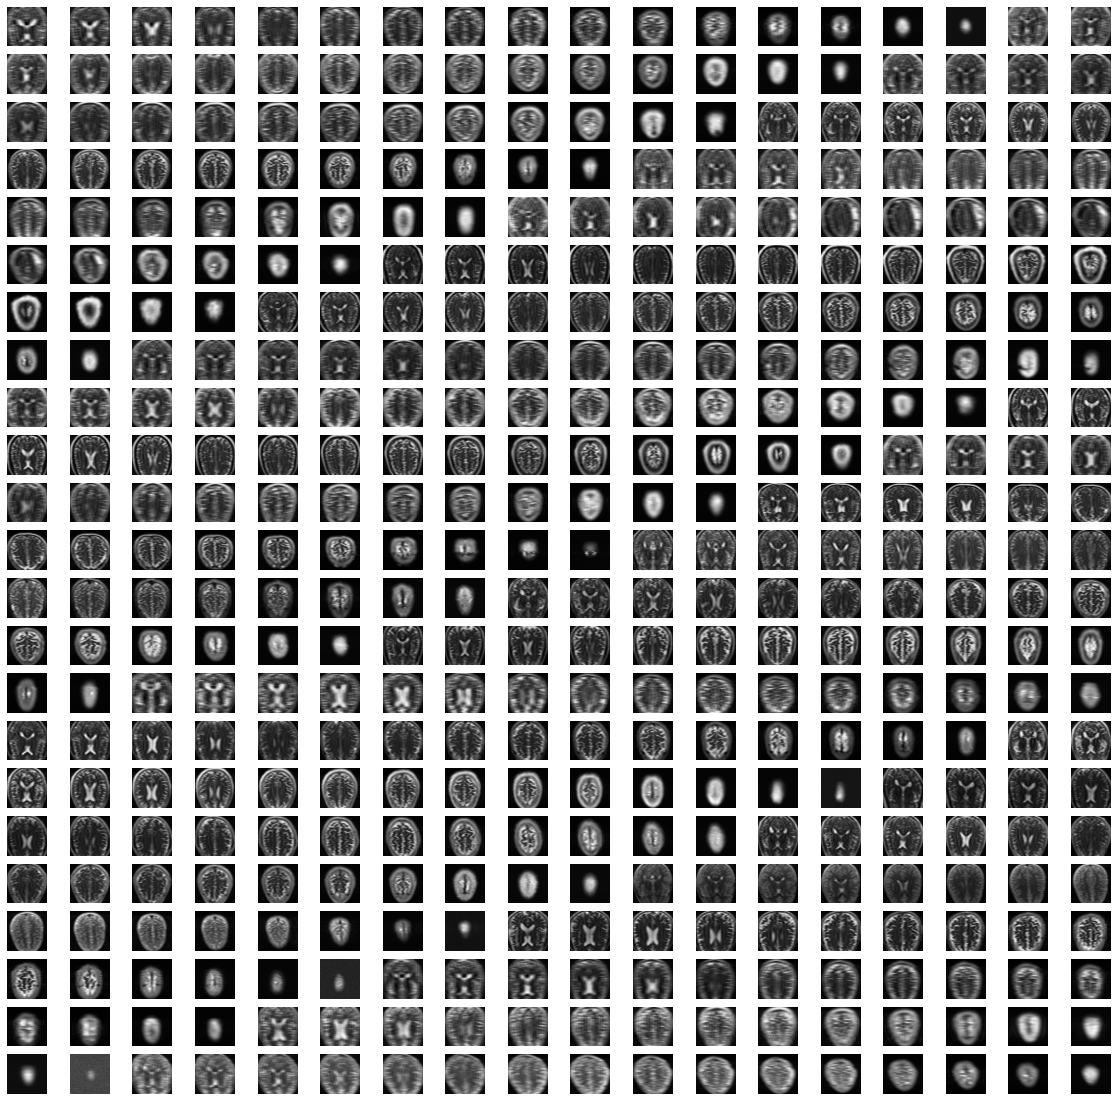

In [30]:
# Visualize the training data
fig, axs = plt.subplots(23, 18)
fig.set_size_inches(20, 20)

slice_idx=0
for ax in axs.ravel():
    slice = data_img[slice_idx]
    X = slice[0].cpu().numpy().reshape(256,256)
    ax.imshow(np.abs(X), cmap='gray')
    ax.set_axis_off()
    slice_idx+=1

In [ ]:
# Visualize the training wavelets
fig, axs = plt.subplots(23, 18)
fig.set_size_inches(20, 20)

slice_idx=0
for ax in axs.ravel():
    slice = data_wt[slice_idx]
    X = slice[0].cpu().numpy().reshape(256,256)
    ax.imshow(np.abs(X), cmap='gray')
    ax.set_axis_off()
    slice_idx+=1

### Define the Neural Network

In [33]:
# Inherit from torch.nn, define basic k-latent AutoEncoder
k_latent = 3000

class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        self.encode = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=8, stride=2, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(16),
            #nn.MaxPool2d(2, stride=None), 
            nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2), 
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, kernel_size=1, stride=2, padding=1), 
            nn.ReLU(),
        )
        #self.latent = nn.Sequential(
        #    nn.Linear(5776, k_latent),
        #    nn.Linear(k_latent,5776)
        #)
        self.decode = nn.Sequential(
            nn.ConvTranspose2d(32, 32, kernel_size=2, stride=2, padding=1,),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.ConvTranspose2d(32, 16, kernel_size=5, stride=2, padding=2,),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 1, kernel_size=8, stride=2, padding=2,),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encode(x)
        #x = x.view(x.size(0), -1) # Flatten for latent layer
        #x = self.latent(x)
        x = self.decode(x)
        return x

### Train the Model

In [70]:
# Training setup
n_epochs = 200
batch_size = 414 #Full batch
batch_loss = np.zeros(n_epochs)

model = AutoEncoder()
#model.to(device)
optimizer = optim.SGD(model.parameters(), lr=1, weight_decay=1e-05)
criterion = nn.MSELoss()

In [71]:
summary(model,input_size=(1,1,256,256))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              --                        --
├─Sequential: 1-1                        [1, 32, 33, 33]           --
│    └─Conv2d: 2-1                       [1, 16, 126, 126]         1,040
│    └─ReLU: 2-2                         [1, 16, 126, 126]         --
│    └─BatchNorm2d: 2-3                  [1, 16, 126, 126]         32
│    └─Conv2d: 2-4                       [1, 32, 63, 63]           12,832
│    └─ReLU: 2-5                         [1, 32, 63, 63]           --
│    └─BatchNorm2d: 2-6                  [1, 32, 63, 63]           64
│    └─Conv2d: 2-7                       [1, 32, 33, 33]           1,056
│    └─ReLU: 2-8                         [1, 32, 33, 33]           --
├─Sequential: 1-2                        [1, 1, 256, 256]          --
│    └─ConvTranspose2d: 2-9              [1, 32, 64, 64]           4,128
│    └─ReLU: 2-10                        [1, 32, 64, 64]           --
│ 

In [72]:
# Do training
for epoch in range(n_epochs):
    # Pick batches for this epoch
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
    for batch_idx, (X, _) in enumerate(train_loader):
        optimizer.zero_grad()   # zero the gradient buffers
        X = torch.reshape(X,(batch_size,1,256,256))
        Y = model(X)
        loss = criterion(X,Y)
        batch_loss[epoch]+=loss.item() # save off the loss
        loss.backward()
        optimizer.step()    # update
    print("Completed epoch: "+str(epoch)+" , Loss: "+str(batch_loss[epoch]))

Completed epoch: 0 , Loss: 0.142332524061203
Completed epoch: 1 , Loss: 0.1074482798576355
Completed epoch: 2 , Loss: 0.060976166278123856
Completed epoch: 3 , Loss: 0.0392337292432785
Completed epoch: 4 , Loss: 0.03002912923693657
Completed epoch: 5 , Loss: 0.025388121604919434
Completed epoch: 6 , Loss: 0.02237389236688614
Completed epoch: 7 , Loss: 0.0199741143733263
Completed epoch: 8 , Loss: 0.01817883364856243
Completed epoch: 9 , Loss: 0.016635801643133163
Completed epoch: 10 , Loss: 0.015321867540478706
Completed epoch: 11 , Loss: 0.014276961795985699
Completed epoch: 12 , Loss: 0.013440500944852829
Completed epoch: 13 , Loss: 0.01226967666298151
Completed epoch: 14 , Loss: 0.011145506054162979
Completed epoch: 15 , Loss: 0.010350827127695084
Completed epoch: 16 , Loss: 0.009954544715583324
Completed epoch: 17 , Loss: 0.009966920129954815
Completed epoch: 18 , Loss: 0.009993640705943108
Completed epoch: 19 , Loss: 0.0090794051066041
Completed epoch: 20 , Loss: 0.008089145645499

### Test It

In [73]:
# Load a test scan in
test_slices = test_df['slice']
X_input = torch.tensor(test_slices[0])
X_input = torch.reshape(X_input,(1,1,256,256)).to(device)

(-0.5, 255.5, 255.5, -0.5)

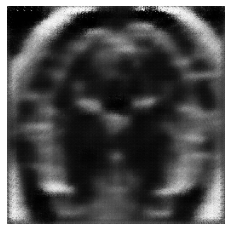

In [77]:
# Put it through our autoencoder and see what we get!
X_output = model(X_input)
X_output = X_output.detach().cpu().numpy().reshape(256,256)
X_reconstruct = decode(X_output)
plt.imshow(np.abs(X_output), cmap='gray')
plt.axis('off')
#plt.savefig('../images/cnn_wavelet_reconstruction.jpg', dpi=200)

(-0.5, 255.5, 255.5, -0.5)

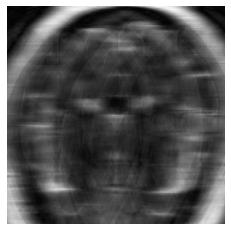

In [76]:
# Compare to truth
plt.imshow(np.abs(X_input.detach().cpu().numpy().reshape(256,256)), cmap='gray')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

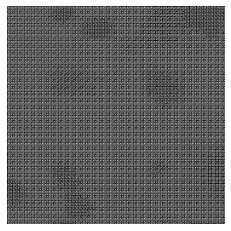

In [28]:
plt.imshow(np.abs(X_reconstruct), cmap='gray')
plt.axis('off')
#plt.savefig('../images/cnn_reconstruction.jpg', dpi=200)

Yikes. Looks like we recovered the wavelets somewhat, but the true image reconstruction is a disaster. A CNN will do better than our shallow NN.